###**Data Science - Experiment 7**

Name - Khushi Jashnani

UID - 2018130017

###**Objective**: 

Separating Spam From Ham using Text Analysis


#### **Case study** : 

Using a emails dataset to identify whether an email is spam or not.


In [ ]:
!pip install scikit-plot

In [ ]:
# importing the necessary libraries

import seaborn as sns
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline 

from tqdm import tqdm
from scipy.stats import randint
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from IPython.display import display 

from sklearn.metrics import mean_absolute_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8

In [ ]:
# Connecting/Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks/DS/Labs/Exp7

/content/drive/MyDrive/Colab Notebooks/DS/Labs/Exp7


### **1.1 Load the dataset (Use pandas )**

In [ ]:
# Reading the training dataset
data = pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
data.tail()

,text,spam
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0
5727,Subject: news : aurora 5 . 2 update aurora ve...,0


#### **Exploratory Data Analysis of the dataset**

How many emails are in the dataset?

In [ ]:
data.shape

(5728, 2)

**Answer:**  There are 5728 emails present in the dataset.

How many of the emails are spam?


In [ ]:
data[data['spam'] == 1]

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
1363,Subject: are you ready to get it ? hello ! v...,1
1364,Subject: would you like a $ 250 gas card ? do...,1
1365,"Subject: immediate reply needed dear sir , i...",1
1366,Subject: wanna see me get fisted ? fist bang...,1


**Answer:**  There are 1368 spam emails present in the dataset.

**Question:**

Which word appears at the beginning of every email in the dataset?


**Answer:** 

Subject is the word which is in the beginning of every text in the email dataset

**Question:**

Could a spam classifier potentially benefit from including the frequency of the word that appears in every email?

**Answer:** 

Yes - the number of times the word appears might help us differentiate spam from ham.

**Question:**

How many characters are in the longest email in the dataset (where longest is measured in terms of the maximum number of characters)?

**Answer:** 

In [ ]:
longest_email_char_count = 0
for email in data['text']:
    if len(email) > longest_email_char_count:
        longest_email_char_count = len(email)

print("Longest email in the dataset consists of ",longest_email_char_count, " characters.")

Longest email in the dataset consists of  43952  characters.


In [ ]:
# Check for null values
data.isnull().sum()

text    0
spam    0
dtype: int64

In [ ]:
# Checking the information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [ ]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = data.shape

df1 = data.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\nAnalysis: The dataset doesn\'t have any duplicates')
else:
    print(f'\nAnalysis: Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Analysis: Number of duplicates dropped/fixed ---> 33


In [ ]:
df1.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


### **2.1 -Preparing the Corpus**

In [ ]:
stopWords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "would", "should", "could", "ought", "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've", "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "cannot", "couldn't", "mustn't", "let's", "that's", "who's", "what's", "here's", "there's", "when's", "where's", "why's", "how's", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very"]

In [ ]:
len(stopWords)

174

In [ ]:
!pip install nltk

In [ ]:
#Filtering the text/ Text Preprocessing
import string
from nltk.stem.porter import PorterStemmer

corpus = df1.copy()

def preprocessor(i, text):
    
    text = text.lower()
    if i == corpus.shape[0] - 1:
        print("\nFor example :\n")
        print(text+"\n")
    # Converting the text into lowercase 
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    if i == corpus.shape[0] - 1:
        print(text+"\n")
    # Removal of punctuations from the corpus
    text = ' '.join([word for word in text.split() if word not in string.punctuation])
    if i == corpus.shape[0] - 1:
        print(text+"\n")
    # Removal of stop words from the text
    text = ' '.join([word for word in text.split() if word not in stopWords])
    # Converting every word in the text into it's root word
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    if i == corpus.shape[0] - 1:
        print(text+"\n")
    if i == corpus.shape[0] - 1:
        print(text+"\n")
    i = i + 1
    return text

for i in tqdm(range(corpus.shape[0])):
    corpus.loc[i,'text'] = preprocessor(i, corpus['text'][i])

corpus.head()

100%|██████████| 5695/5695 [00:59<00:00, 96.07it/s] 


For example :

subject: news : aurora 5 . 2 update  aurora version 5 . 2  - the fastest model just got faster -  epis announces the release of aurora , version 5 . 2  aurora the electric market price forecasting tool is already  legendary for power and speed . we ' ve combined a powerful chronological  dispatch model with the capability to simulate the market from 1  day to 25 + years . add to that a risk analysis section , powered by user  selectable monte carlo & / or latin hypercube modeling , enough  portfolio analysis power to please the toughest critic , & inputs and  outputs from standard excel & access tables and you ' ve got one of most  powerful tools in the market .  just a few months ago we expanded our emissions modeling  capabilities , added our quarterly database update , increased the speed  of the entire model , and made  but that wasn ' t enough .  we ' ve done it again . some of the operations that we ' ve  included . . .  two new reporting enhancements .  the first

,text,spam
0,subject natur irresist corpor ident lt realli ...,1
1,subject stock trade gunsling fanni merril muzo...,1
2,subject unbeliev new home made easi im want sh...,1
3,subject color print special request addit info...,1
4,subject money get softwar cd softwar compat ai...,1


**After step 1, 2, 3, 4, 5 :**The text is now clean up with the removal of all punctuations, stopwords and then by stemming

#### **A little more EDA**

In [ ]:
corpus['spam'].value_counts()

0    4327
1    1368
Name: spam, dtype: int64

            Target Variable Distribution           


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0, flags=flags)


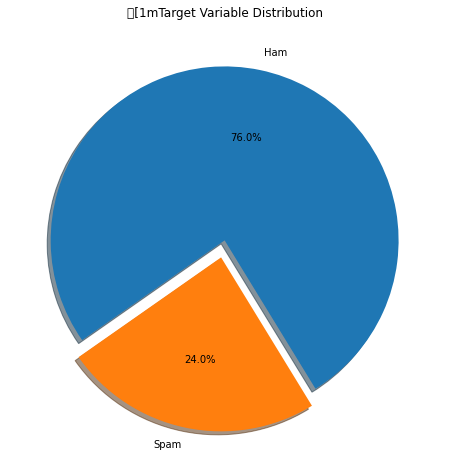

In [ ]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(corpus['spam'].value_counts(), labels=['Ham','Spam'], counterclock=False, shadow=True, 
        explode=[0,0.1], autopct='%1.1f%%', radius=1, startangle=215)
plt.title('\033[1mTarget Variable Distribution')
plt.show()

Here we can see that the target column in not balanced. This is the case of imbalanced dataset

In [ ]:
#Visualising the most frequent words

spamdata = corpus[corpus['spam']== 1]
spamdata = spamdata['text']
hamdata = corpus[corpus['spam']== 0]
hamdata= hamdata['text']

def most_frequent_words(data):
    words = ' '.join(data)
    map = {}
    for word in words.split():
        if word in map:
            map[word] = map[word] + 1
        else:
            map[word] = 0
    map = sorted(map.items(), key=lambda item: item[1], reverse=True)
    # print(map)
    return map[:20]
        

print('Most-common spam words', most_frequent_words(spamdata))
print('Most-common ham words', most_frequent_words(hamdata))

Most-common spam words [('subject', 1576), ('will', 1449), ('s', 1332), ('compani', 1064), ('com', 998), ('mail', 916), ('busi', 896), ('email', 864), ('can', 830), ('inform', 817), ('receiv', 726), ('e', 697), ('get', 693), ('money', 661), ('pleas', 618), ('free', 605), ('make', 602), ('http', 602), ('market', 599), ('time', 592)]
Most-common ham words [('enron', 13334), ('ect', 11409), ('subject', 8564), ('vinc', 8467), ('will', 6757), ('hou', 5566), ('s', 5145), ('kaminski', 4753), ('pleas', 4439), ('com', 4396), ('cc', 3861), ('re', 3806), ('j', 3668), ('thank', 3536), ('can', 3401), ('pm', 3246), ('forward', 2942), ('research', 2712), ('time', 2533), ('meet', 2519)]


#### **Step 6 - Building the Document Term Matrix**

In [ ]:
corpus

,text,spam
0,subject natur irresist corpor ident lt realli ...,1
1,subject stock trade gunsling fanni merril muzo...,1
2,subject unbeliev new home made easi im want sh...,1
3,subject color print special request addit info...,1
4,subject money get softwar cd softwar compat ai...,1
...,...,...
5690,subject re research develop charg gpg forward ...,0
5691,subject re receipt visit jim thank invit visit...,0
5692,subject re enron case studi updat wow day s su...,0
5693,subject re interest david pleas call shirley c...,0


In [ ]:
vec = TfidfVectorizer()
vec_data = vec.fit_transform(corpus['text'])

dtm = pd.DataFrame(vec_data.toarray(), columns = vec.get_feature_names())
dtm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,aaaenerfax,aadedeji,aagraw,aal,aaldou,aaliyah,aall,aanalysi,...,zwzm,zxghlajf,zyban,zyc,zygoma,zymg,zzmacmac,zzn,zzncacst,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question:**

How many terms are in dtm?

**Answer:**  

There are 25653 terms in the document term matrix.

We convert the processed text to a matrix of TF-IDF features using TfidfVectorizer which is equivalent to CountVectorizer followed by TfidfTransformer.

### **3.1 – Building machine learning model**

In [ ]:
emailsSparse = pd.DataFrame(dtm)
print(emailsSparse.shape)

(5695, 25654)


In [ ]:
emailsSparse['spamOrNot'] = data['spam']

In [ ]:
emailsSparse.head()

,aa,aaa,aaaenerfax,aadedeji,aagraw,aal,aaldou,aaliyah,aall,aanalysi,...,zxghlajf,zyban,zyc,zygoma,zymg,zzmacmac,zzn,zzncacst,zzzz,spamOrNot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
emailsSparse.shape

(5695, 25654)

In [ ]:
from sklearn.model_selection import train_test_split
#Splitting the data intro training & testing sets

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(emailsSparse.drop(['spamOrNot'], axis=1), emailsSparse['spamOrNot'], train_size=0.7)
print("Training set size: ", X_train.shape[0])
print("Testing set size: ", X_test.shape[0])

Training set size:  3986
Testing set size:  1709


In [ ]:
X_train.head()

,aa,aaa,aaaenerfax,aadedeji,aagraw,aal,aaldou,aaliyah,aall,aanalysi,...,zwzm,zxghlajf,zyban,zyc,zygoma,zymg,zzmacmac,zzn,zzncacst,zzzz
3216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.head()

3216    0
4773    0
4505    0
5624    0
5449    0
Name: spamOrNot, dtype: int64

In [ ]:
#Lets create a table to store the results of various models 

metrics = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
metrics.index=['CART (spamCART)','Random Forest (spamRF)']
metrics


,Accuracy,Precision,Recall,F1-score,AUC-ROC score
CART (spamCART),0.0,0.0,0.0,0.0,0.0
Random Forest (spamRF),0.0,0.0,0.0,0.0,0.0


In [ ]:
#Classification Summary Function
def train_classification_summary(model, i):
    training_acc = round(accuracy_score(y_train, model.predict(X_train)),3)*100  
    print('{}{}\033[1m Training Evaluation of {} \033[0m{}{}\n'.format('<'*3,'-'*35,metrics.index[i], '-'*35,'>'*3))
    print('Training Accuracy = {}%'.format(training_acc))
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_train, model.predict(X_train)))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_train, model.predict(X_train)))
    print("AUC: ", roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    auc_roc(y_train, model.predict_proba(X_train), curves=['each_class'])
    plt.show()

In [ ]:
#Classification Summary Function
def test_classification_summary(model, pred, i):
    metrics.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100   
    metrics.iloc[i]['Precision']=round(precision_score(y_test, pred),3)*100 #, average='weighted'
    metrics.iloc[i]['Recall']=round(recall_score(y_test, pred),3)*100 #, average='weighted'
    metrics.iloc[i]['F1-score']=round(f1_score(y_test, pred),3)*100 #, average='weighted'
    metrics.iloc[i]['AUC-ROC score']=round(roc_auc_score(y_test, pred),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Testing Evaluation of {} \033[0m{}{}\n'.format('<'*3,'-'*35,metrics.index[i], '-'*35,'>'*3))
    print('Testing Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}'.format(round(f1_score(y_test, pred),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))
    print("AUC: ", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    auc_roc(y_test, model.predict_proba(X_test), curves=['each_class'])
    plt.show()


### **1. Classfication and Regression Tree (CART):**

<<<----------------------------------- Training Evaluation of CART (spamCART) ----------------------------------->>>

Training Accuracy = 100.0%

 Confusiton Matrix:
 [[3018    0]
 [   0  968]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3018
           1       1.00      1.00      1.00       968

    accuracy                           1.00      3986
   macro avg       1.00      1.00      1.00      3986
weighted avg       1.00      1.00      1.00      3986

AUC:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


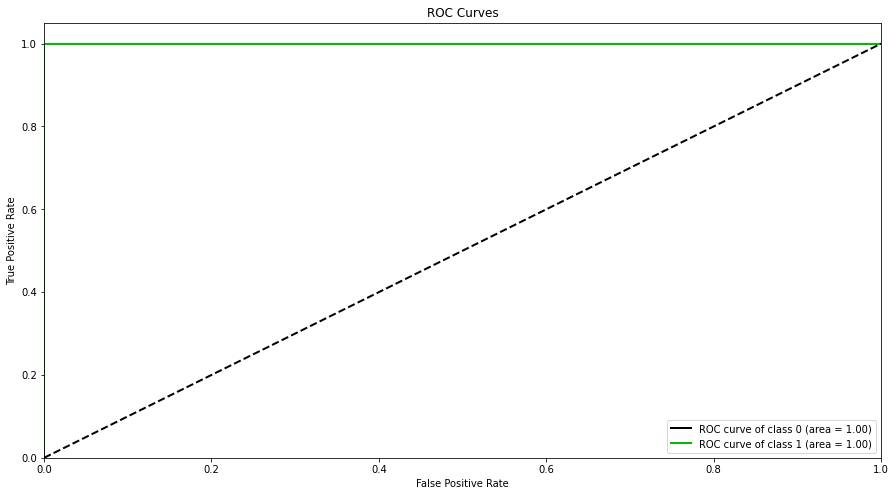

In [ ]:
# Fitting the Classfication and Regression Tree (CART)

np.random.seed(123)
spamCART = DecisionTreeClassifier()
cart = spamCART.fit(X_train, y_train)
train_classification_summary(cart, 0)

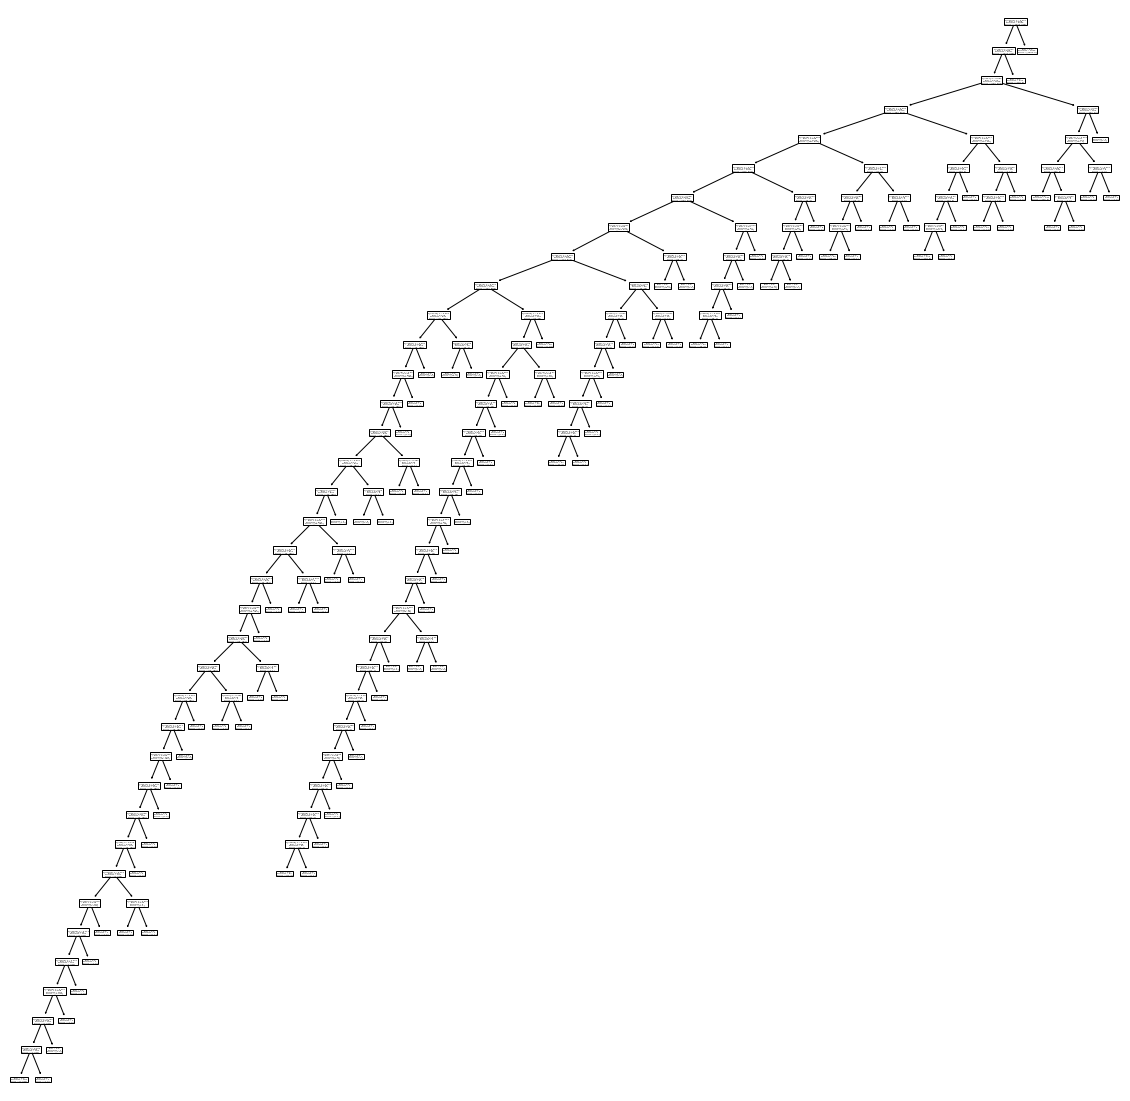

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(cart)
plt.show()

### **2. Random Forest Classifier (RF):**

<<<----------------------------------- Training Evaluation of Random Forest (spamRF) ----------------------------------->>>

Training Accuracy = 100.0%

 Confusiton Matrix:
 [[3018    0]
 [   0  968]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3018
           1       1.00      1.00      1.00       968

    accuracy                           1.00      3986
   macro avg       1.00      1.00      1.00      3986
weighted avg       1.00      1.00      1.00      3986

AUC:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


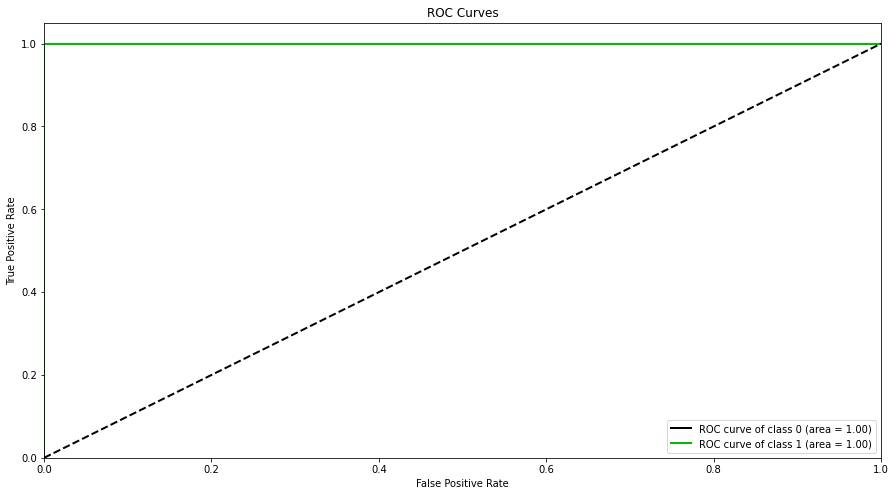

In [ ]:
# Fitting the Random Forest Classifier (RF)

np.random.seed(123)
spamRF = RandomForestClassifier()
RF = spamRF.fit(X_train, y_train)
train_classification_summary(RF, 1)

### **4.1 – Evaluating on the Test Set**

<<<----------------------------------- Testing Evaluation of CART (spamCART) ----------------------------------->>>

Testing Accuracy = 95.5%
F1 Score = 90.4

 Confusiton Matrix:
 [[1270   39]
 [  38  362]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1309
           1       0.90      0.91      0.90       400

    accuracy                           0.95      1709
   macro avg       0.94      0.94      0.94      1709
weighted avg       0.95      0.95      0.95      1709

AUC:  0.9376031321619557


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


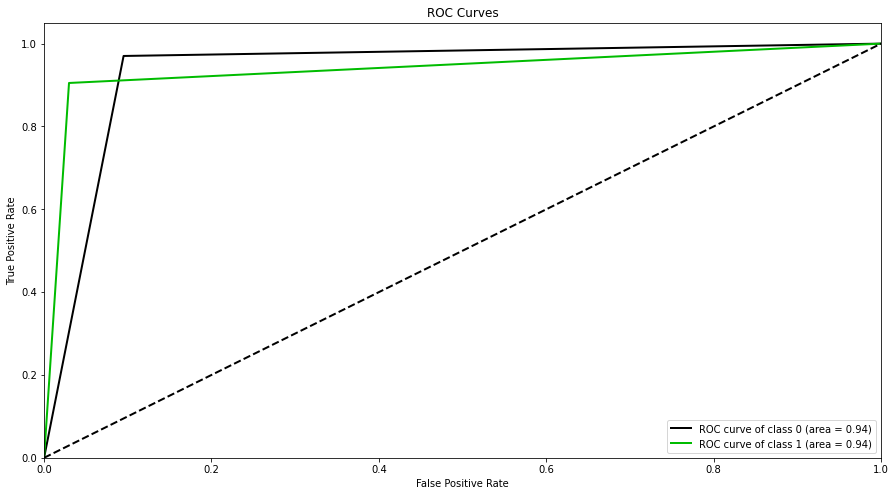

In [ ]:
pred = cart.predict(X_test)
test_classification_summary(cart, pred, 0)

<<<----------------------------------- Testing Evaluation of Random Forest (spamRF) ----------------------------------->>>

Testing Accuracy = 97.39999999999999%
F1 Score = 94.1

 Confusiton Matrix:
 [[1305    4]
 [  41  359]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1309
           1       0.99      0.90      0.94       400

    accuracy                           0.97      1709
   macro avg       0.98      0.95      0.96      1709
weighted avg       0.97      0.97      0.97      1709

AUC:  0.9979153934300993


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


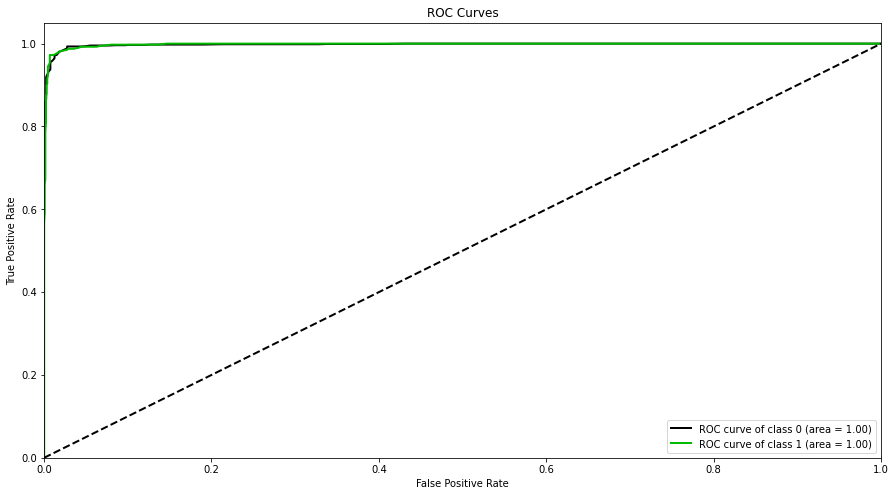

In [ ]:
pred = RF.predict(X_test)
test_classification_summary(RF, pred, 1)

**Analysis:**  

After comparing both the models,  we see that Random Forest outperforms the CART model in all the aspects such as AUC, Accuracy, Precision, recall and F1 Score.

### **Conclusion -**

Through this experiment, I understood how to analysis textual data.

I understood how to preprocess text data, transform into vectorizers and then pass it for training.

I also understood that ensemble models like random forests are a strong modeling technique and much more robust than a single decision tree. The aggregation of multiple decision trees limit overfitting as well as error due to bias and therefore yield useful results.
